In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install fiona
!pip install rasterio
!pip install torchviz
!pip install albumentations

     |████████████████████████████████| 14.7MB 299kB/s 
     |████████████████████████████████| 18.1MB 240kB/s 
     |████████████████████████████████| 51kB 3.1MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=dc3f52cca81b33d10c71fa9696ed6c64070d1f51aae40e5b466480d7abe37a1a
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
     |████████████████████████████████| 634kB 3.4MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=7c999de5e12ad0adf6f37b7668aa9078cf11711fa099da79a47bb11e1fe077ff
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Weak_Learners_ML2020')

In [4]:
import scipy
import numpy as np
import seaborn as sns
import fiona
import rasterio
from shapely import geometry
from rasterio.mask import mask
import copy

def extractor(frame,points,size=7,normalize=True,labeling=False):
  '''
  The extractor fuction takes in three paramters:
  
    1. frame - The image to be subdevided. Resterio type file
    2. points - fiona collection file with coordinates of points
    3. size - size of the window
    4. data normalization - normolize the data boolean
    5. require labels if the data containes labels. Boolean
    
  Return:
  
    1. List of bathces with the give size
    2. List of coordinates
    3. List of labels
  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
  Example:
      frame = rasterio.open("pp_1_sat_modified1.tif")
      points = fiona.open("alltreepoints1.shp", "r")
      collection = extractor(frame,points,size=7)
  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
  '''
  img = frame.read((5,3,2)).T.astype('uint32')
  if normalize:
    img = img/np.max(img)

  assert img.shape[1]>img.shape[2], "channles are in the right place!"+str(img.shape)
  map_tree_speices = {'е':0, 'б':1, 'п':2, "El'":0, "Bereza":1, "Pichta":2, "Sosna":3} 
  img_point,locations,labels = [],[],[]

  for p in range(len(points)):

        try:  
              point = np.array(frame.index(*points[p]['geometry']['coordinates']))
              box = img[(point[1]-size):point[1]+size,
                        (point[0]-size):point[0]+size,:].copy()
              if labeling:
                  labels.append(map_tree_speices[ points[p]['properties']['specie'] ]) 
              img_point.append(box)
              locations.append(point)
              del box
        except:
              pass
              #print("None coordinate/close to edge")
  return img_point, locations, labels

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import scipy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import fiona
import rasterio
from shapely import geometry
from rasterio.mask import mask
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix

# from extractor_helper import extractor

# CNN

In [0]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data
from torchviz import make_dot, make_dot_from_trace
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensor

**Get data**

In [0]:
test2_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test2/pp_2_sat_modified.tif")
test2_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test2/points_2_modified_Copy.shp", "r")

test3_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test3/pp_3_sat_modified.tif")
test3_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test3/targets_Copy.shp", "r")

test4_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test4/pp_4_sat_modified_spline.tif")
test4_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test4/modified_points_Copy.shp", "r")

In [0]:
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                A.RandomRotate90(),
                A.Transpose(),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
                A.Blur(blur_limit=3),
                A.OpticalDistortion(),
                A.GridDistortion(num_steps=3),
            ],
            p = 0.5
        ),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)

In [0]:
class TreesData():
  def __init__(self, X, y, aug_pipeline=None):
    super().__init__()
    self.X = X
    self.y = torch.tensor(y, dtype=torch.long)
    if aug_pipeline:
        self.aug_pipeline = aug_pipeline
    else:
        self.aug_pipeline = A.Compose([ToTensor()], p=1)
    
  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self, idx):
    augmented = self.aug_pipeline(image = self.X[idx])['image']
    return augmented, self.y[idx]

**Define model**

In [0]:
from math import ceil

In [0]:
CNN = lambda LAST_LAYER_SIZE: nn.Sequential(
  
  nn.Conv2d(3,64,2, padding=1),
  nn.MaxPool2d(2,2),
  nn.ReLU(),
  nn.Dropout(0.5),

  nn.Conv2d(64,128,2, padding=1),
  nn.MaxPool2d(2,2),
  nn.ReLU(),
  nn.Dropout(0.5),

  nn.Flatten(),
  nn.Linear(128*LAST_LAYER_SIZE*LAST_LAYER_SIZE, 4),
)

**Train model**

In [0]:
def train(epochs, net, criterion, optimizer,
          train_loader, val_loader, scheduler=None,
          verbose=True, save_dir=None):
  
  net.to(device)
  train_loss_history = []
  val_loss_history = []
  val_loss_not_improved = 0
  best_val_loss = 999
  patience = 30
  best_model = None
  best_predicted_y_percent = None
  best_predicted_y = None
  best_true_y = None
  for epoch in range(1,epochs+1):
    net.train()
    total_instances = 0
    matched = 0
    train_loss = 0
    for X, y in train_loader:
      X = X.to(device)
      y = y.to(device)
      pred = net(X)
      loss = criterion(pred, y)
      train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_pred_arg = np.argmax(pred.cpu().detach(), axis=1)
      matched += (train_pred_arg == y.cpu().detach()).sum()
      total_instances += len(train_pred_arg)
    train_acc = matched.item()/total_instances
   
    net.eval()
    total_instances = 0
    matched = 0
    predicted_y = np.array([])
    predicted_y_percent = np.array([])
    true_y = np.array([])
    val_loss = 0
    for X, y in val_loader:
      X = X.to(device)
      y = y.to(device)
      val_pred = net(X)
      val_loss += criterion(val_pred, y).item()

      predicted_y_percent = np.concatenate((predicted_y_percent, val_pred.cpu().detach()), axis=None)
      predicted_y = np.concatenate((predicted_y, np.argmax(val_pred.cpu().detach(), axis=1)), axis=None)
      true_y = np.concatenate((true_y, y.cpu().detach()), axis=None)
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc = (predicted_y == true_y).sum()/len(true_y)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
  
    if scheduler is not None:
      schduler.step()
    
      
    if best_val_loss > val_loss:
      #print(f'Validation loss decreased {best_val_loss:.6f} -> {val_loss:.6f}')
      best_val_loss = val_loss
      best_model = copy.deepcopy(net)
      best_predicted_y_percent = predicted_y_percent
      best_predicted_y = predicted_y
      best_true_y = true_y
      val_loss_not_improved = 0
    else:
      val_loss_not_improved += 1
    
    if verbose:
      print('Epoch {:3}/{} || Loss:  Train {:.6f} | Validation {:.6f} || Accuracy: Train {:.2%} | Validation {:.2%} || F1-score {:.2f} || Not improved {} out of {}'\
            .format(epoch, epochs, train_loss, val_loss, train_acc, val_acc, f1_score(true_y, predicted_y, average='macro'), val_loss_not_improved, patience))

    if val_loss_not_improved == patience:
      break

  net = best_model
  return best_predicted_y, best_predicted_y_percent, best_true_y, train_loss_history, val_loss_history

3 5 7 8 9 11 13 15 

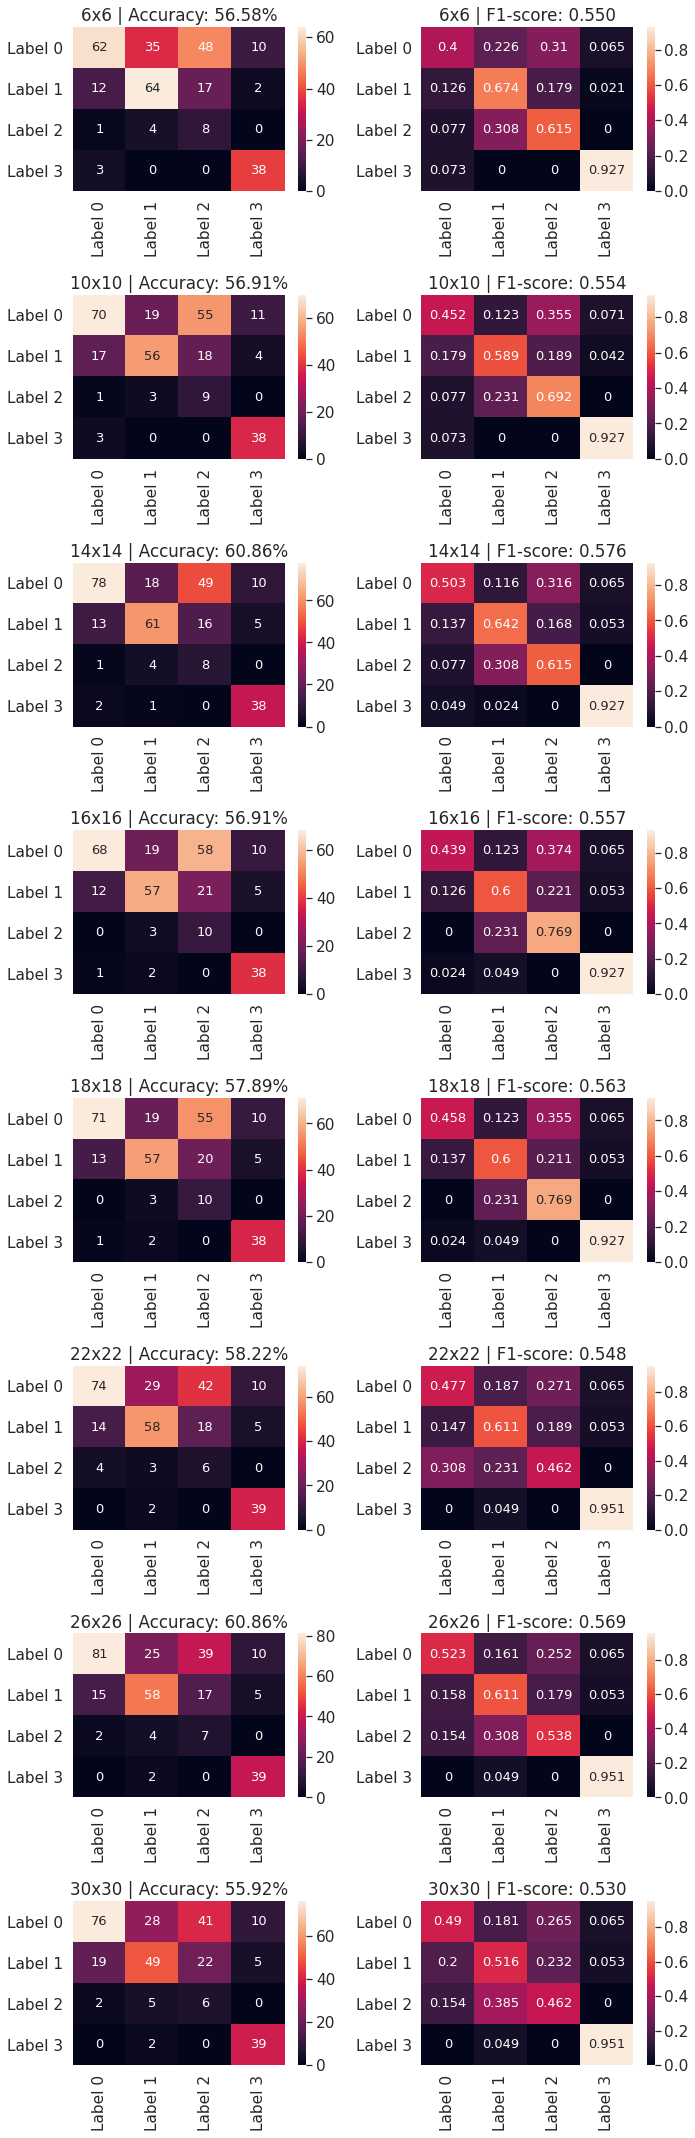

In [27]:
SIZES = [3, 5, 7, 8, 9, 11, 13, 15] # 12.5, 
fig, axes = plt.subplots(nrows=len(SIZES), ncols=2, figsize=(10, 30))
row = 0

for SIZE in SIZES:
    print(SIZE, end=' ')
    LAST_LAYER_SIZE = ceil(ceil(SIZE*2/2)/2)

    patch2, coordinates2, labels2, = extractor(test2_img, test2_points, size=SIZE, normalize=True, labeling=True)
    patch3, coordinates3, labels3, = extractor(test3_img, test3_points, size=SIZE, normalize=True, labeling=True)
    patch4, coordinates4, labels4, = extractor(test4_img, test4_points, size=SIZE, normalize=True, labeling=True)

    patch = np.concatenate((patch2, patch3, patch4),axis=0)
    labels = np.concatenate((labels2,labels3,labels4),axis=0)

    # We do stratified splitting to have balanced train and test set.
    x_train, x_test, y_train, y_test = train_test_split(patch, labels, test_size=.3, shuffle=True, stratify=labels, random_state=42)
    train_data = TreesData(x_train, y_train, augmentation_pipeline)
    test_data = TreesData(x_test, y_test)
    unique, counts = np.unique(labels, return_counts=True)

    # Settings
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = CNN(LAST_LAYER_SIZE)
    weights = torch.tensor(counts.max()/counts, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(net.parameters())
    scheduler = None
    train_loader = torch_data.DataLoader(train_data, batch_size=50, shuffle=True)
    val_loader = torch_data.DataLoader(test_data, batch_size=10, shuffle=True)

    # Training
    epochs = 500
    predicted_y, predicted_y_percent, true_y, train_loss_history, val_loss_history = train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler, verbose=False)
    predicted_y_percent = torch.softmax(torch.tensor(predicted_y_percent.reshape(-1, 4)), axis=1).detach().numpy()

    # Plot results
    SIZE_WHOLE = SIZE*2
    f1_score_size = f1_score(true_y, predicted_y, average='macro')
    accuracy_size = (predicted_y == true_y).sum()/len(true_y)
    label_names = [f'Label {i}' for i in range(4)]
    cm = confusion_matrix(true_y, predicted_y)
    cm_df = pd.DataFrame(cm, columns=label_names, index=label_names)
    cm_df_rel = pd.DataFrame(cm/cm.sum(1)[:, np.newaxis], columns=label_names, index=label_names)

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(cm_df, annot=True, annot_kws={"size": 13}, fmt='g', ax=axes[row][0])
    axes[row][0].set_title(f'{SIZE_WHOLE}x{SIZE_WHOLE} | Accuracy: {accuracy_size:.2%}')

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(round(cm_df_rel, 3), annot=True, annot_kws={"size": 13}, fmt='g', ax=axes[row][1])
    axes[row][1].set_title(f'{SIZE_WHOLE}x{SIZE_WHOLE} | F1-score: {f1_score_size:.3f}')

    row += 1

plt.tight_layout()
plt.show()